In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

from perspective_transformation import undistort_image, getCalibrationParameters
from gradient_color import my_pipeline 
import sobel_operator
import lane_detect
import curvature


In [17]:
offset = 350

images = os.listdir("test_images/");
image = mpimg.imread("test_images/" + images[0])
img_size = (image.shape[1], image.shape[0])

src = np.float32([[[ 610,  450]], 
                      [[ 680,  450]], 
                      [[ img_size[0]-300,  680]],
                      [[ 380,  680]]])

# Result points        
dst = np.float32([[offset, 0], 
                [img_size[0]-offset, 0], 
                [img_size[0]-offset, img_size[1]], 
                [offset, img_size[1]]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

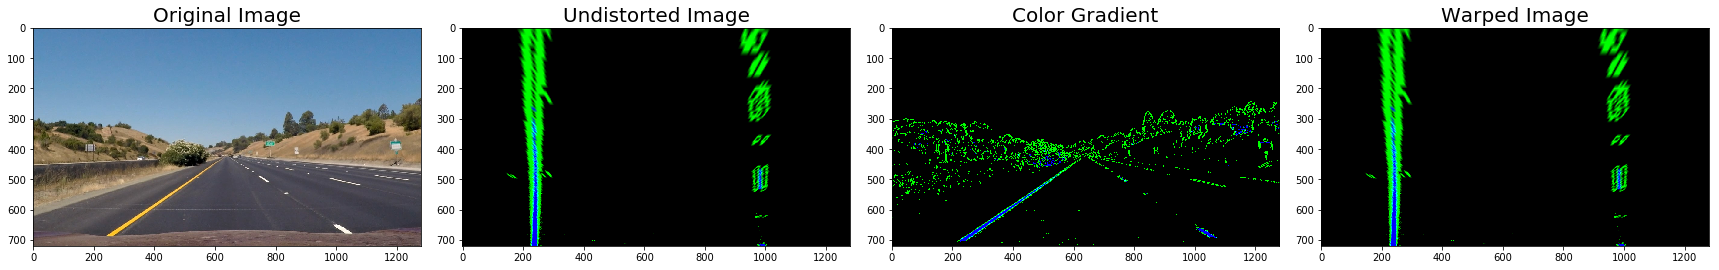

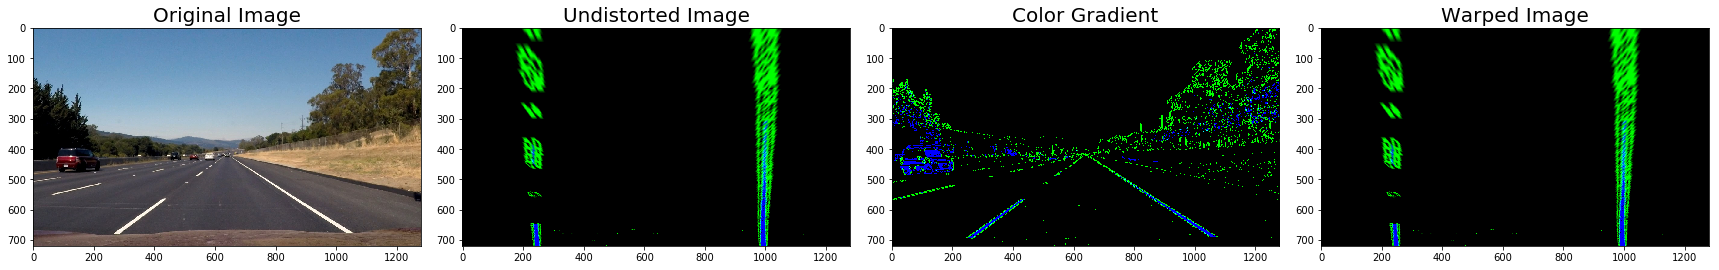

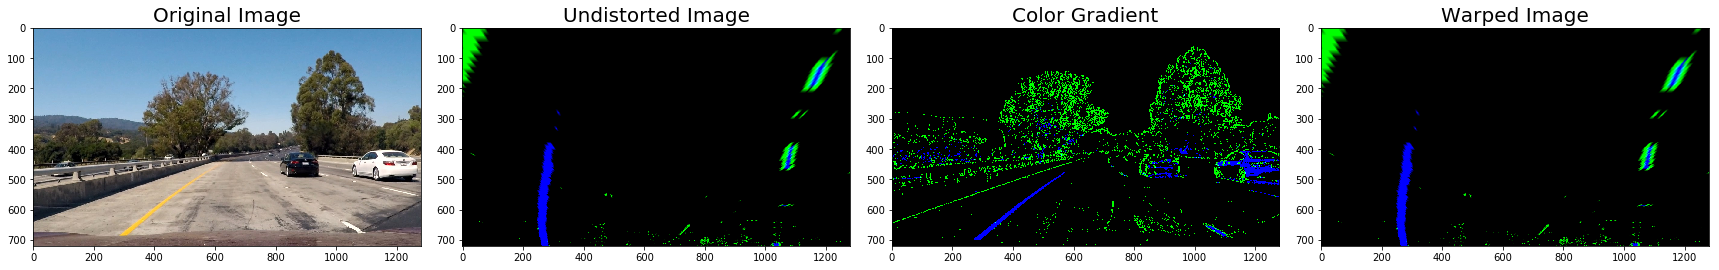

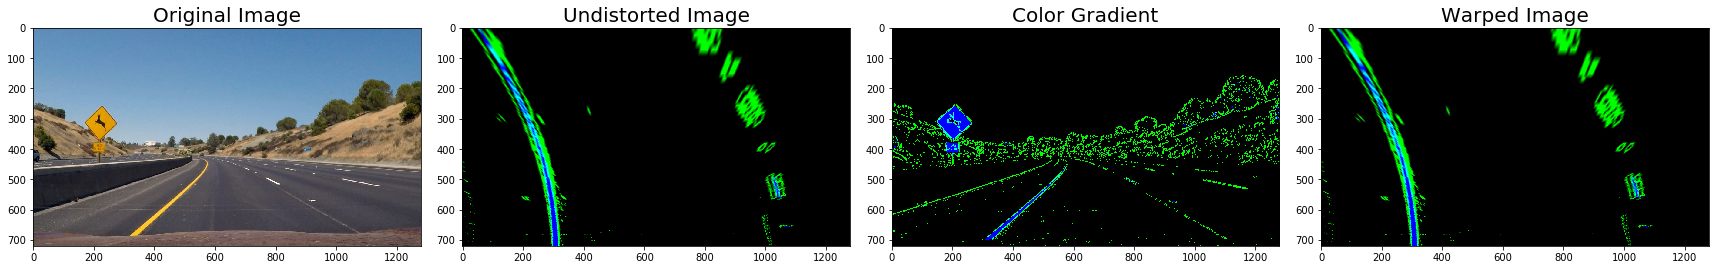

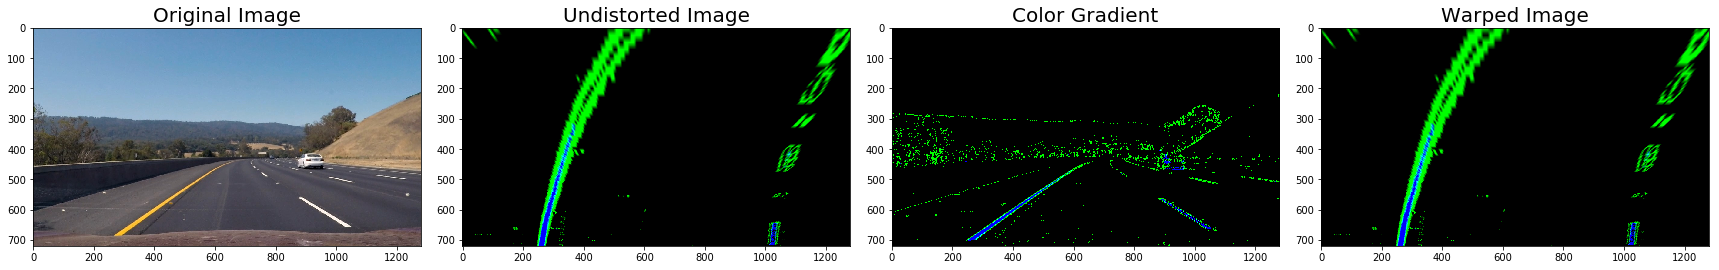

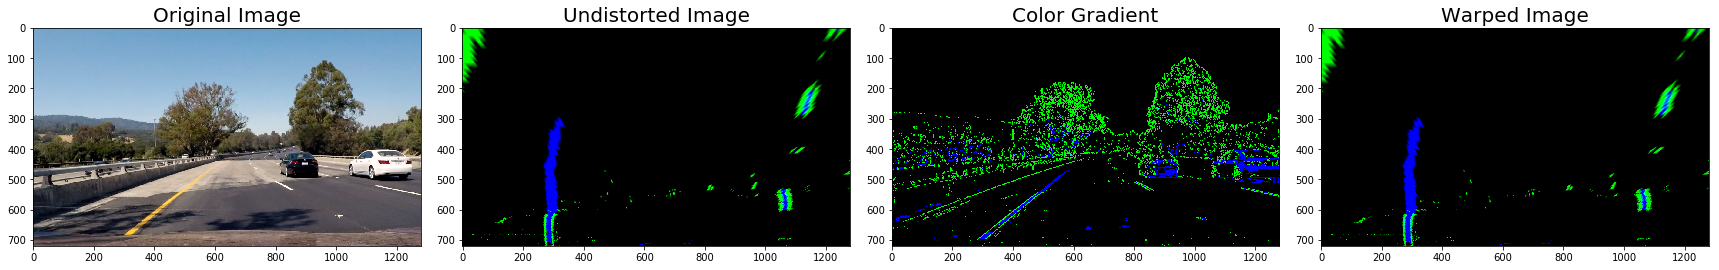

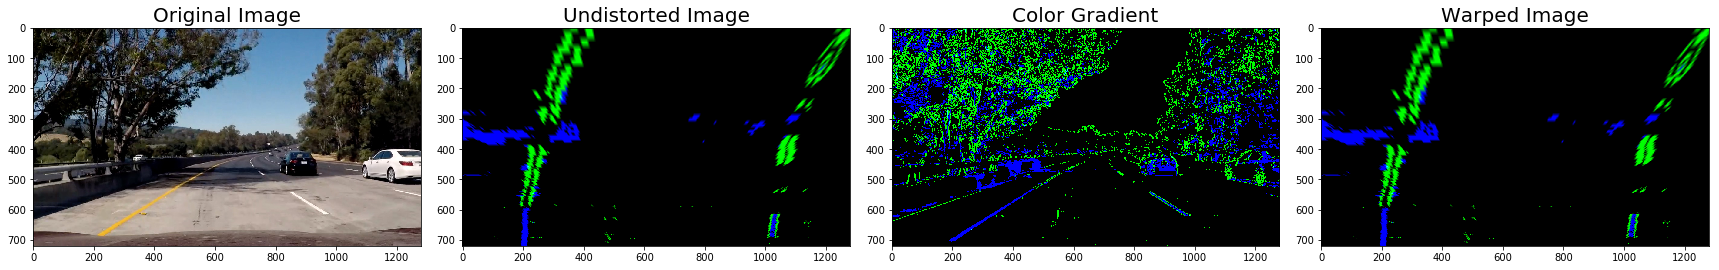

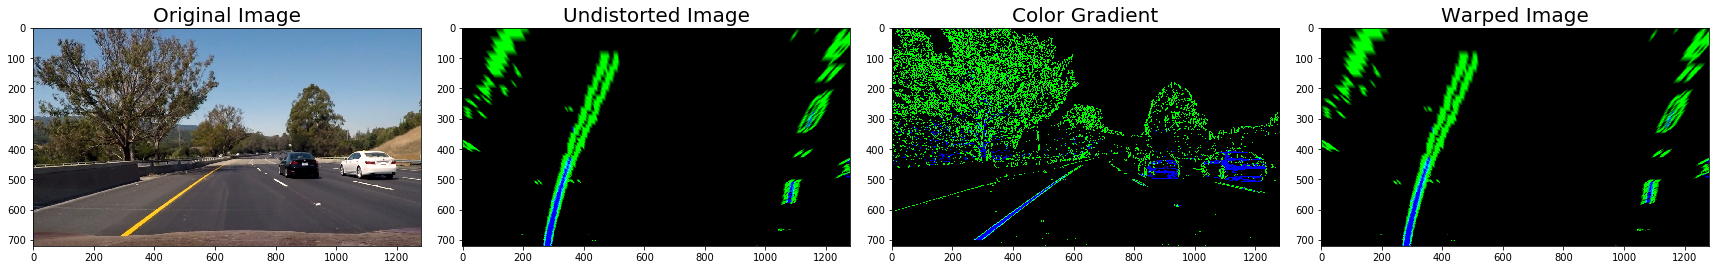

In [10]:
for f in images:
    img = mpimg.imread('./test_images/' + f);

    mtx, dist = getCalibrationParameters()

    undist = undistort_image(img, mtx, dist)

    color_binary = my_pipeline(undist)

    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)

    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Undistorted Image', fontsize=20)
    ax3.imshow(color_binary, cmap='gray')
    ax3.set_title('Color Gradient', fontsize=20)
    ax4.imshow(warped, cmap='gray')
    ax4.set_title('Warped Image', fontsize=20)


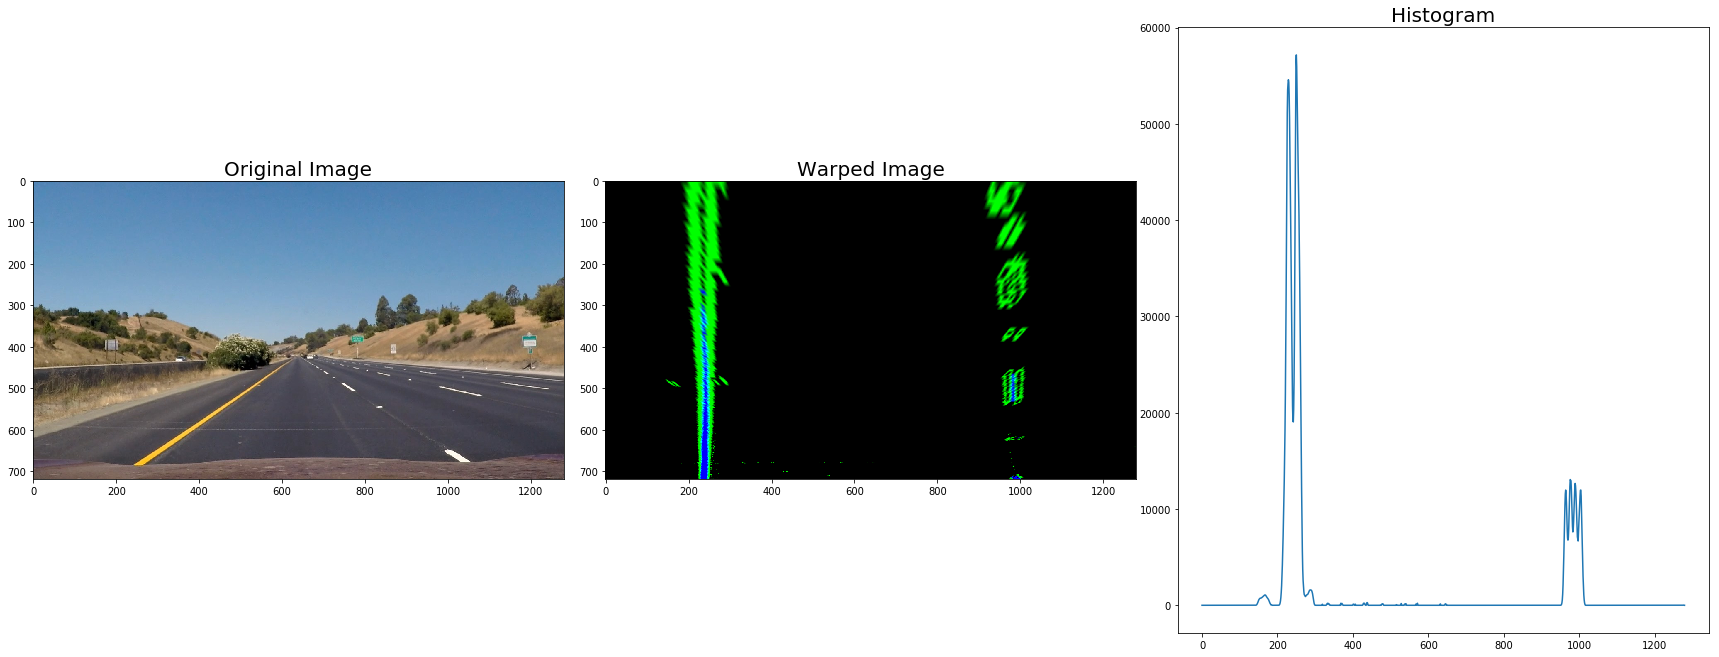

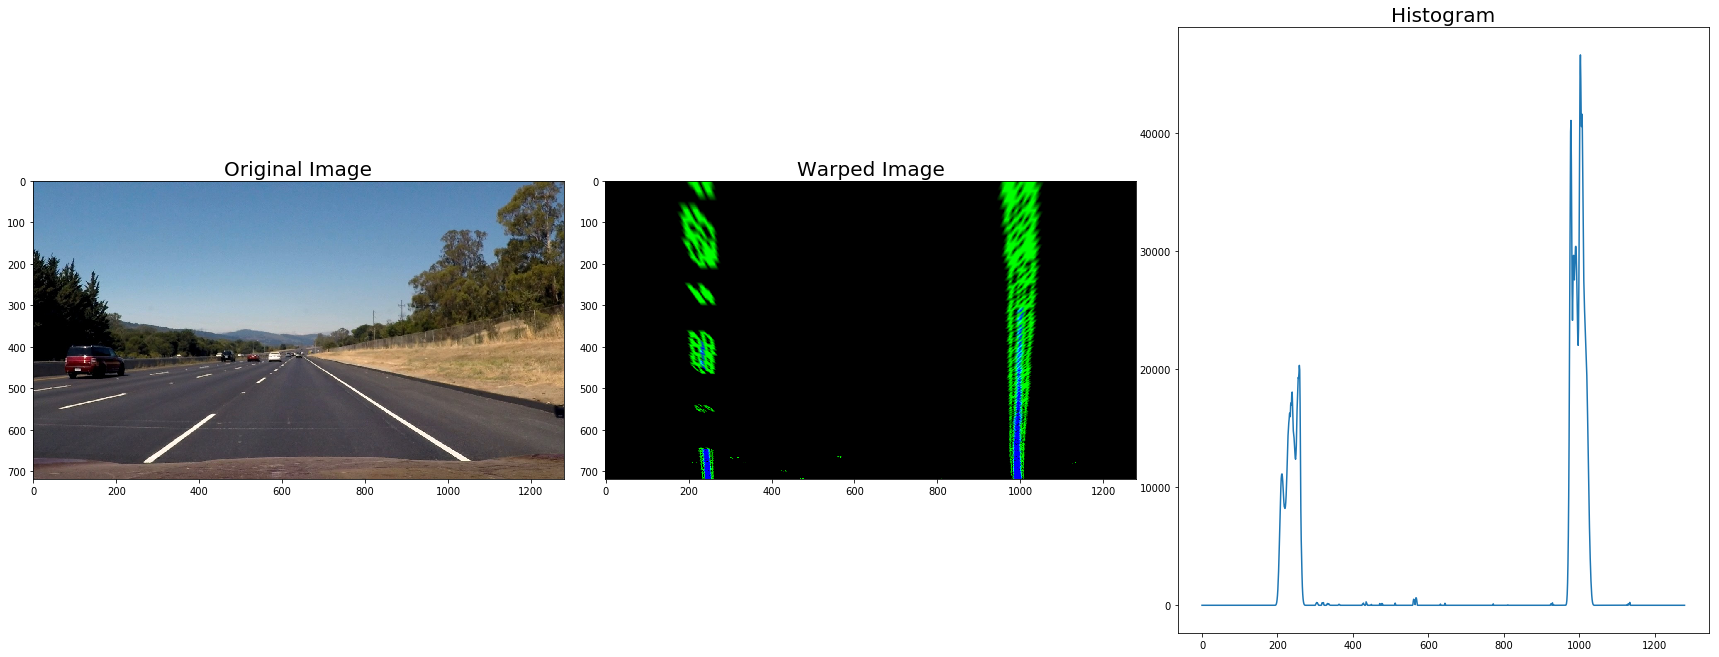

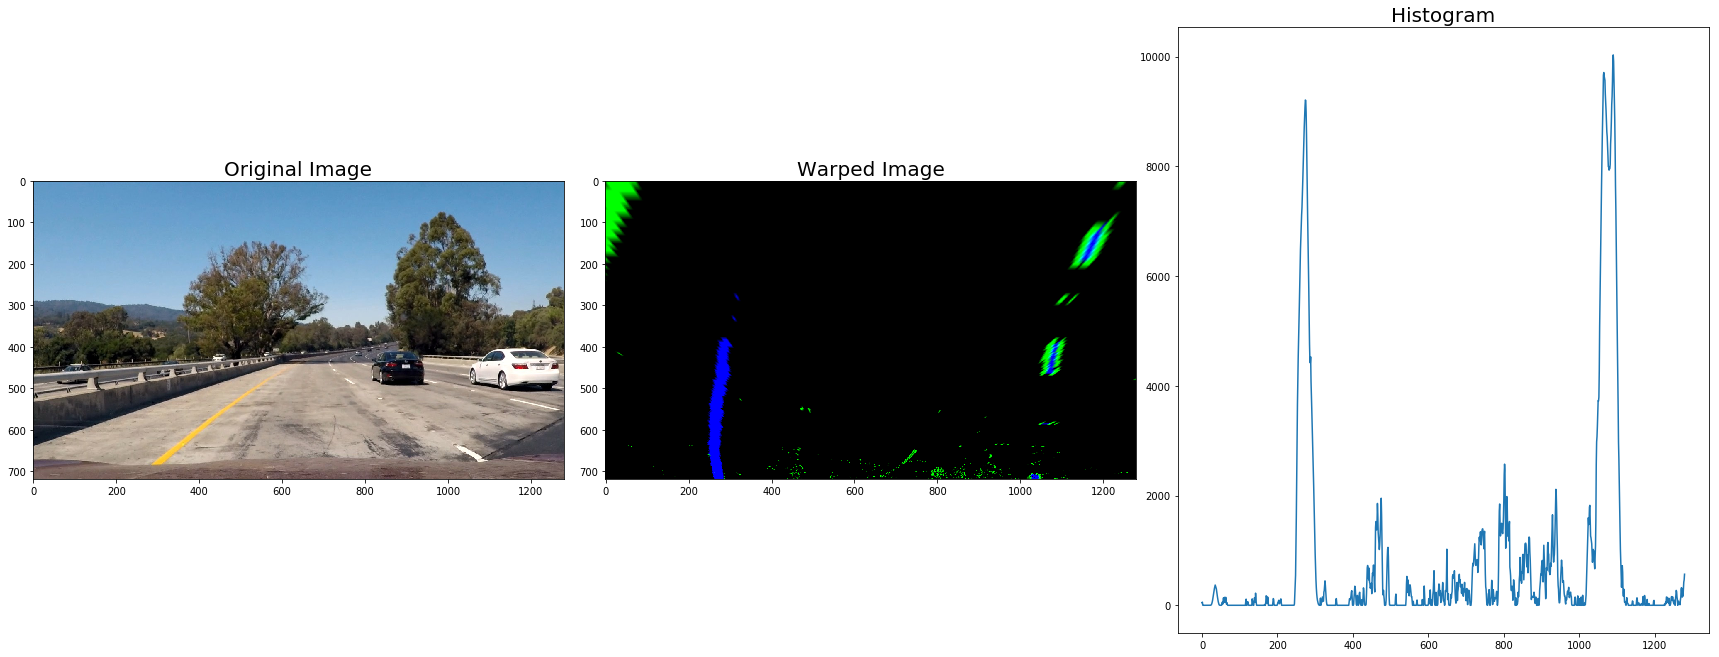

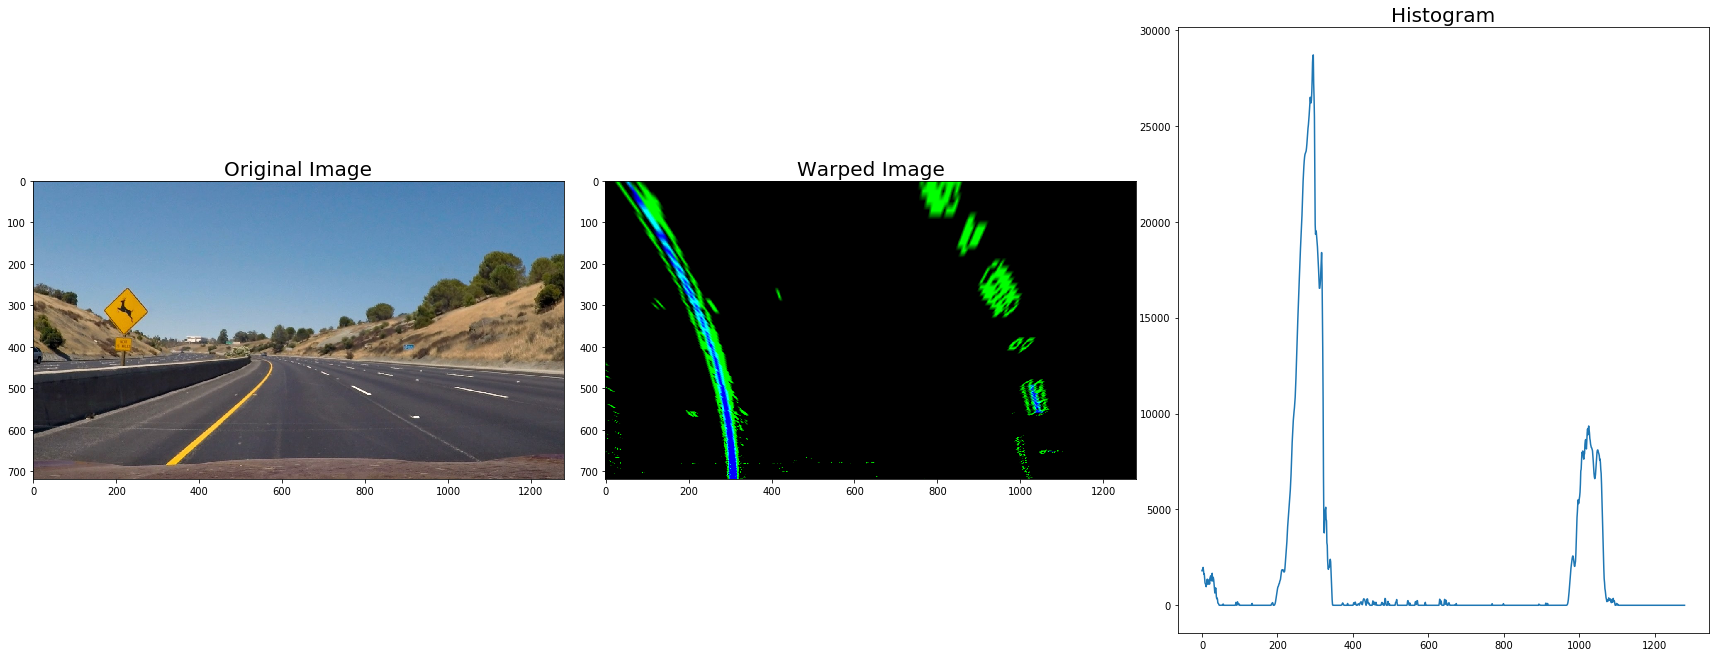

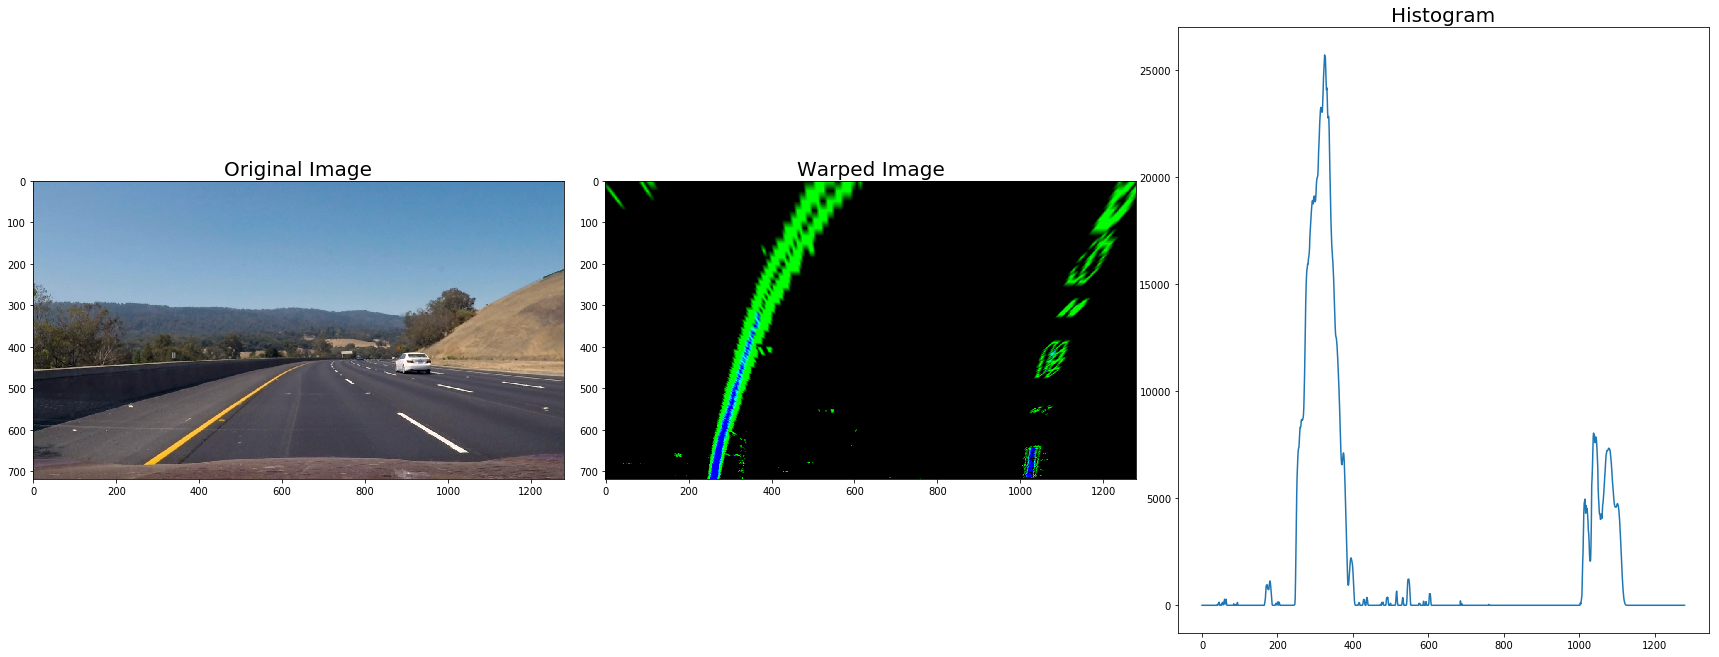

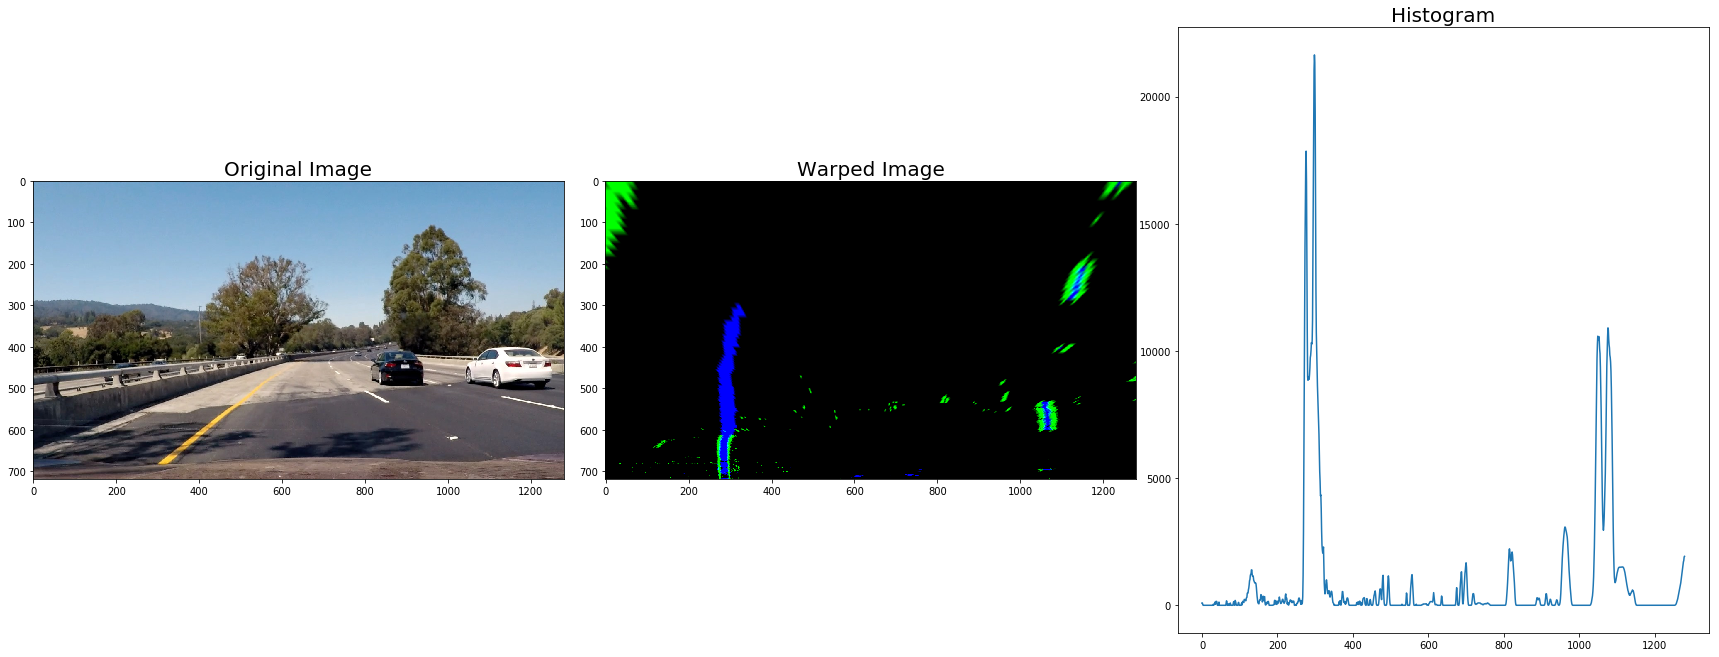

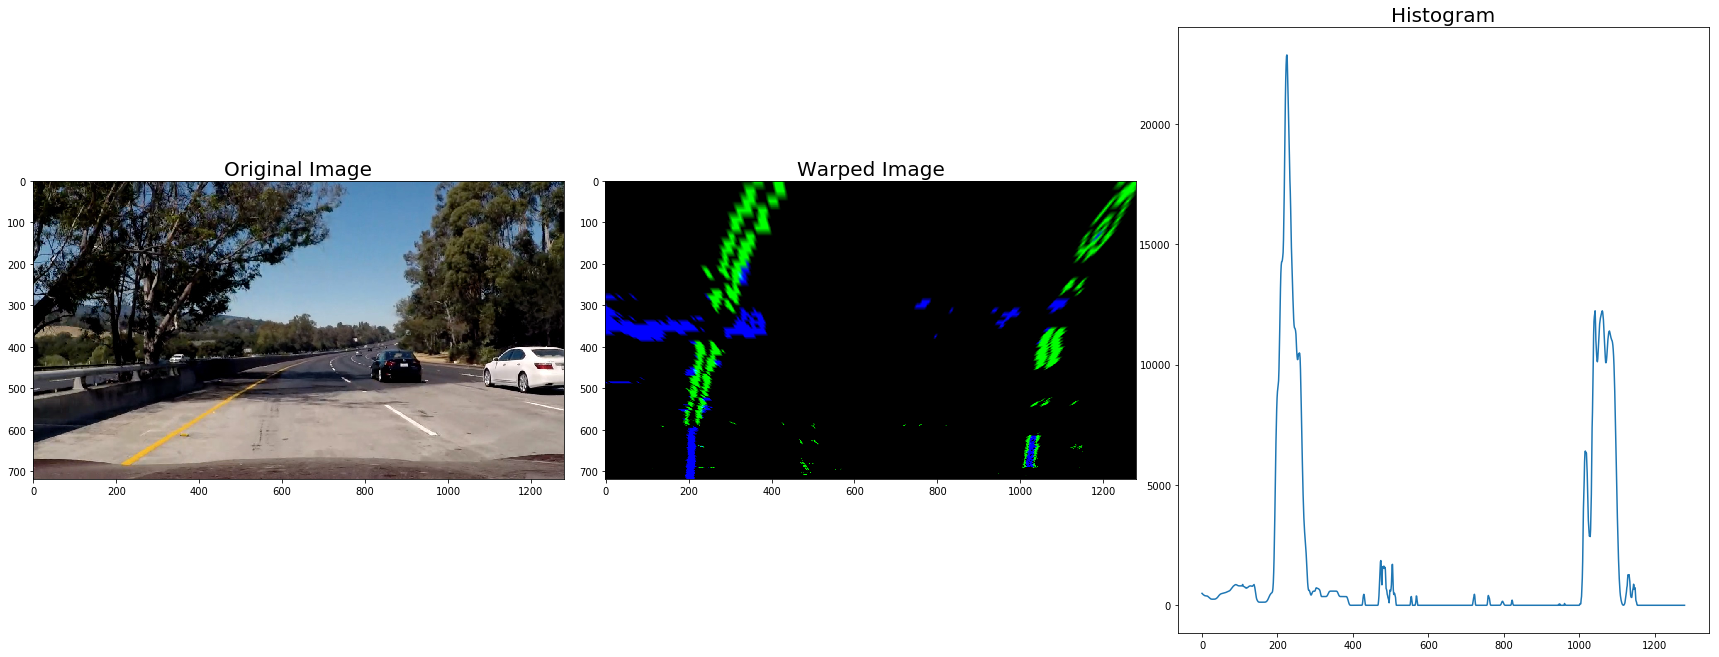

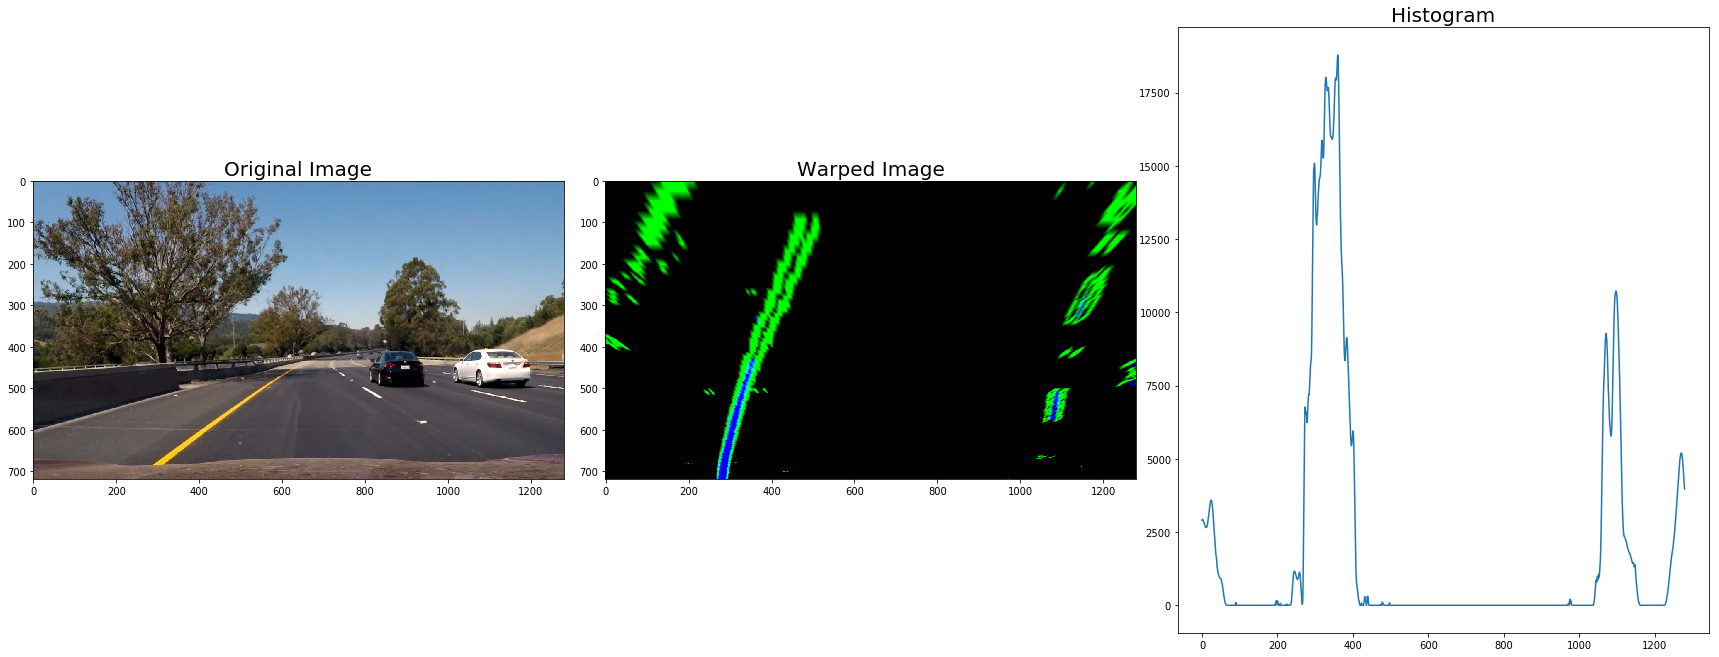

In [18]:
for f in images:
    img = mpimg.imread('./test_images/' + f);

    mtx, dist = getCalibrationParameters()

    undist = undistort_image(img, mtx, dist)

    color_binary = my_pipeline(undist)

    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)

    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    histogram = lane_detect.hist(gray_warped)
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=20)
    ax3.plot(histogram)
    ax3.set_title('Histogram', fontsize=20)
    
    

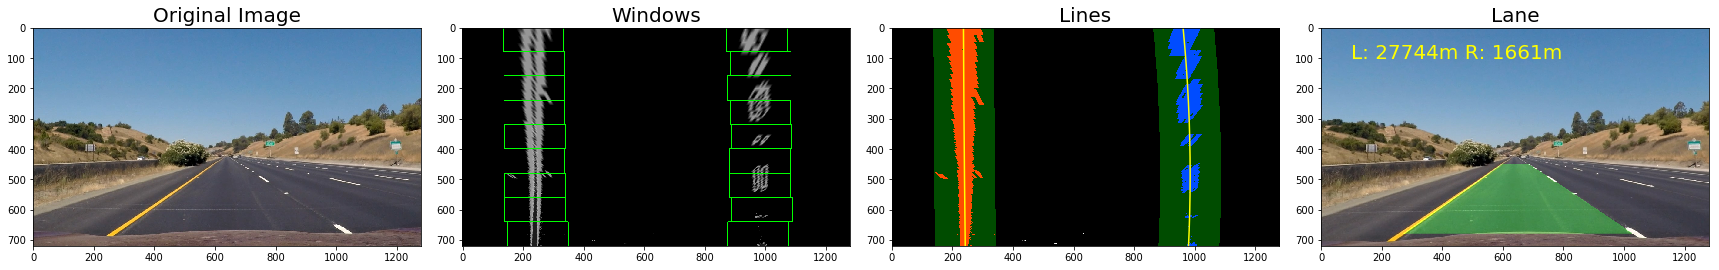

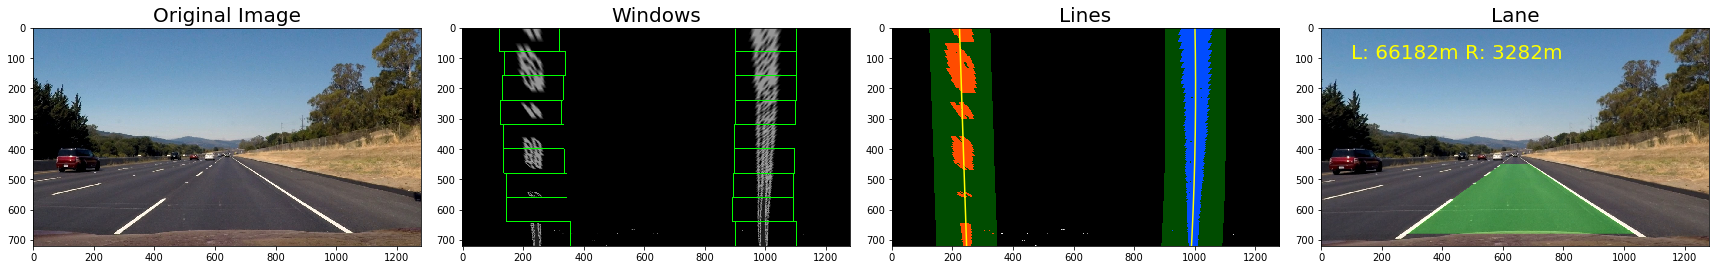

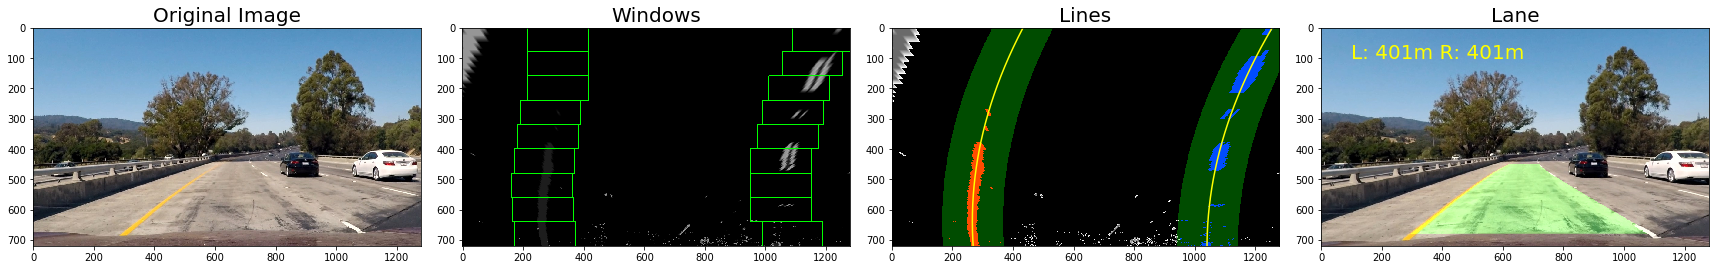

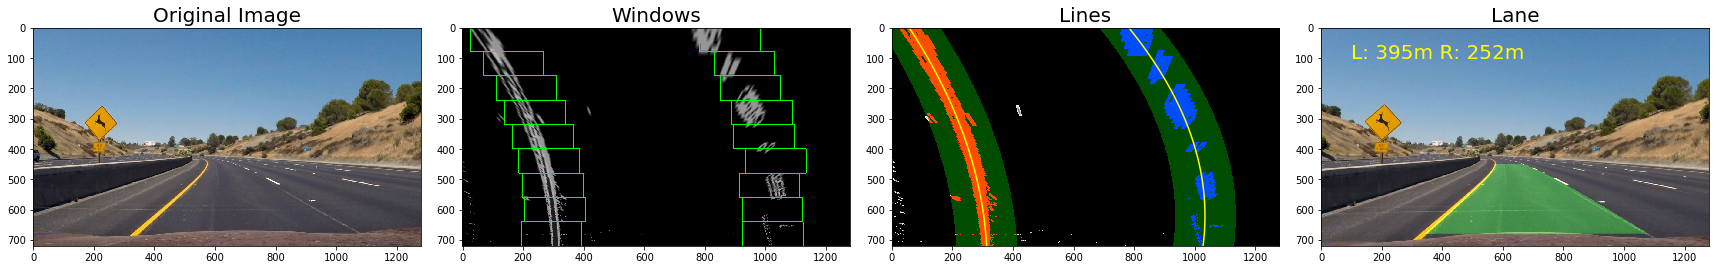

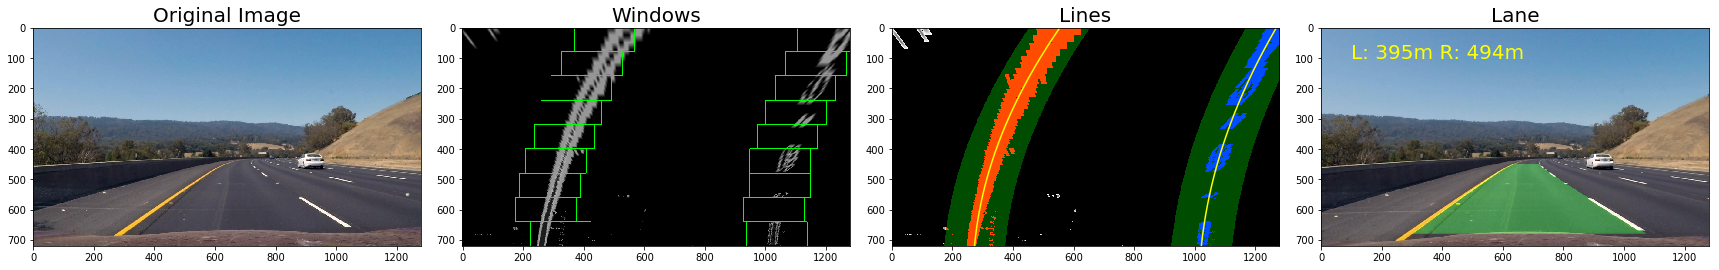

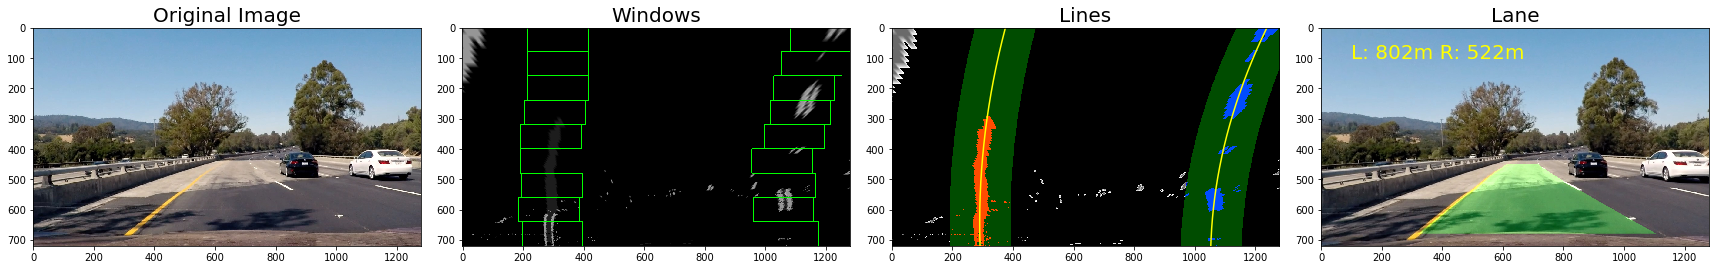

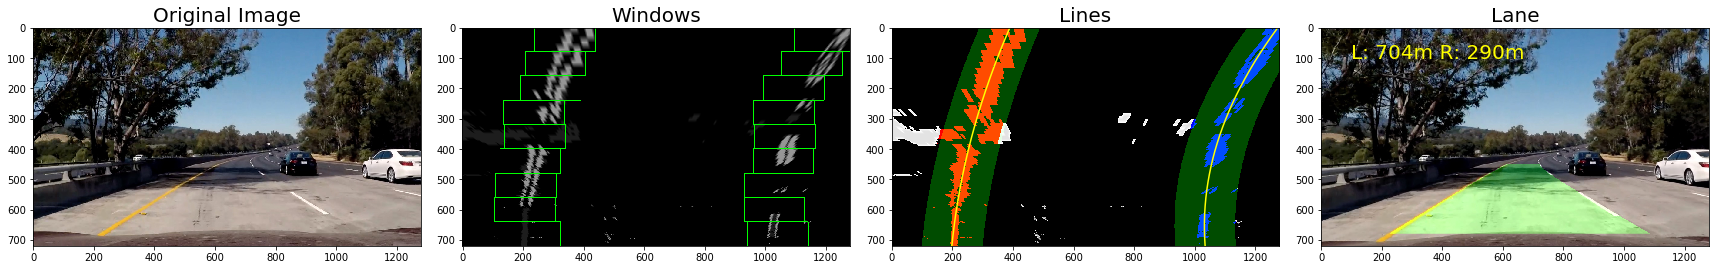

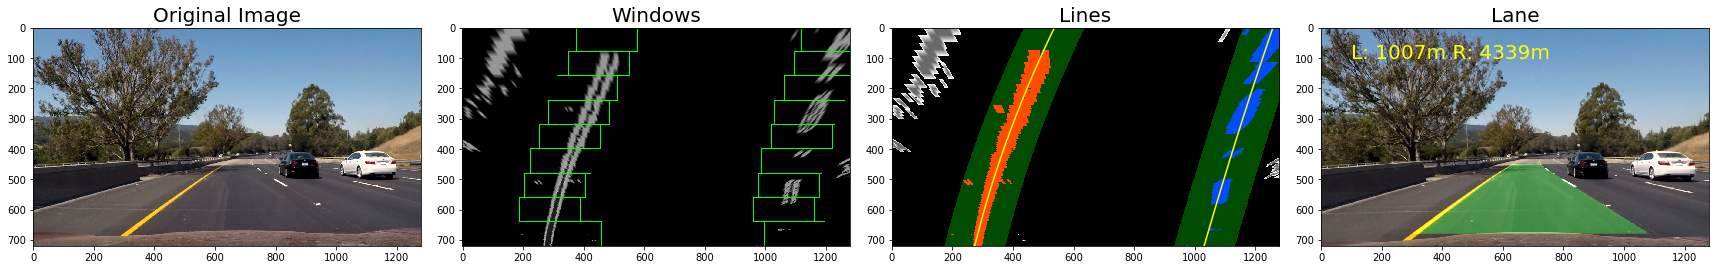

In [19]:
for f in images:
    img = mpimg.imread('./test_images/' + f);

    mtx, dist = getCalibrationParameters()

    undist = undistort_image(img, mtx, dist)

    color_binary = my_pipeline(undist)

    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)

    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    left_fit, right_fit, leftx, lefty, rightx, righty, windows = lane_detect.find_lane_pixels(gray_warped)
    
    out_img, left_fitx, right_fitx, ploty = lane_detect.search_around_poly(gray_warped, left_fit, right_fit)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(gray_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = curvature.measure(ploty, left_fitx, right_fitx)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(windows)
    ax2.set_title('Windows', fontsize=20)
    ax3.imshow(out_img)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax3.set_title('Lines', fontsize=20)
    ax4.imshow(result)
    ax4.text(100, 100, 'L: ' + str(int(left_curverad)) + 'm R: ' + str(int(right_curverad)) + 'm', fontsize=20).set_color('yellow')
    ax4.set_title('Lane', fontsize=20)
    
    

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import line

In [5]:
def process_image(image):
    mtx, dist = getCalibrationParameters()

    undist = undistort_image(image, mtx, dist)

    color_binary = my_pipeline(undist)

    warped = cv2.warpPerspective(color_binary, M, img_size, flags=cv2.INTER_LINEAR)

    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    left_fit, right_fit, leftx, lefty, rightx, righty, windows = lane_detect.find_lane_pixels(gray_warped)
    
    out_img, left_fitx, right_fitx, ploty = lane_detect.search_around_poly(gray_warped, left_fit, right_fit)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(gray_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = curvature.measure(ploty, left_fitx, right_fitx)
    
    text = 'L: ' + str(int(left_curverad)) + 'm R: ' + str(int(right_curverad)) + 'm'
    
    cv2.putText(result, text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    
    return result
    

In [7]:
video = 'project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('video_results/' + video, audio=False)

[MoviePy] >>>> Building video video_results/project_video.mp4
[MoviePy] Writing video video_results/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:12<00:00,  6.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_results/project_video.mp4 

Wall time: 3min 13s


In [6]:
video = 'challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('video_results/' + video, audio=False)

[MoviePy] >>>> Building video video_results/challenge_video.mp4
[MoviePy] Writing video video_results/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [01:08<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_results/challenge_video.mp4 

Wall time: 1min 9s
